##Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import  mean_squared_error
import lightgbm as lgb

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Importing dataset

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/train_E1GspfA.csv')
test = pd.read_csv('/content/drive/MyDrive/test_6QvDdzb.csv')
submit = pd.read_csv('/content/drive/MyDrive/sample_4E0BhPN.csv')

In [ ]:
df = train.copy()

In [ ]:
df.head()

,date,hour,demand
0,2018-08-18,9,91
1,2018-08-18,10,21
2,2018-08-18,13,23
3,2018-08-18,14,104
4,2018-08-18,15,81


##Feature Engineering

In [ ]:
 # Extract date feature
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].apply(lambda x: x.year)
df['month'] = df['date'].apply(lambda x: x.month)
df['day'] = df['date'].apply(lambda x: x.day)
df['day_of_week'] = df['date'].apply(lambda x: x.dayofweek)
df['is_quarter_date'] = df['date'].apply(lambda x: x.quarter)
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x>4 else 0)

df.drop(['date'], axis=1, inplace=True)

In [ ]:
df.head()

,hour,demand,year,month,day,day_of_week,is_quarter_date,is_weekend
0,9,91,2018,8,18,5,3,1
1,10,21,2018,8,18,5,3,1
2,13,23,2018,8,18,5,3,1
3,14,104,2018,8,18,5,3,1
4,15,81,2018,8,18,5,3,1


In [ ]:
# Extract date feature for test
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].apply(lambda x: x.year)
test['month'] = test['date'].apply(lambda x: x.month)
test['day'] = test['date'].apply(lambda x: x.day)
test['day_of_week'] = test['date'].apply(lambda x: x.dayofweek)
test['is_quarter_date'] = test['date'].apply(lambda x: x.quarter)
test['is_weekend'] = test['day_of_week'].apply(lambda x: 1 if x>4 else 0)

test.drop(['date'], axis=1, inplace=True)

In [ ]:
test.head()

,hour,year,month,day,day_of_week,is_quarter_date,is_weekend
0,0,2021,3,1,0,1,0
1,1,2021,3,1,0,1,0
2,2,2021,3,1,0,1,0
3,3,2021,3,1,0,1,0
4,5,2021,3,1,0,1,0


<Axes: xlabel='hour', ylabel='demand'>

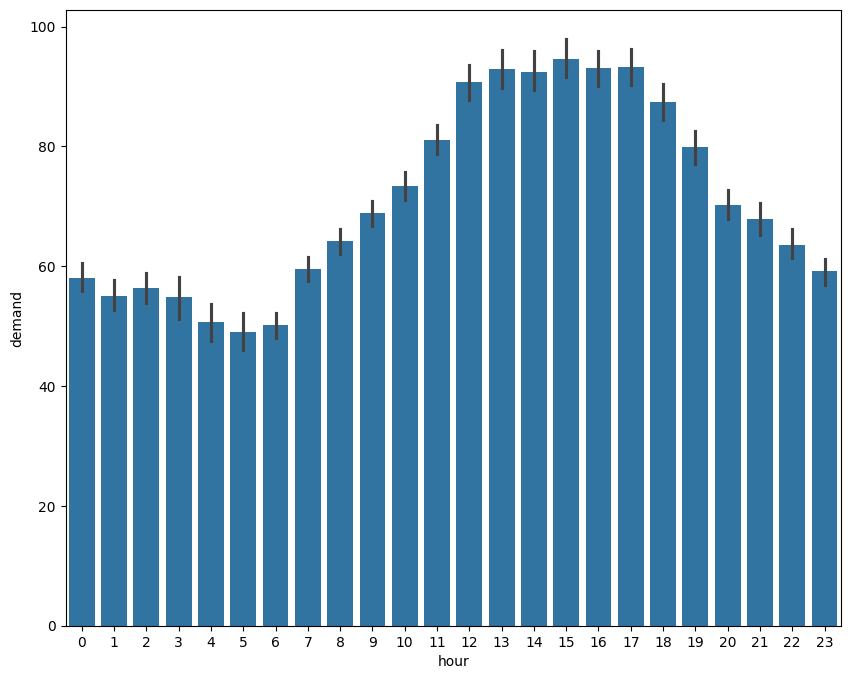

In [ ]:
plt.figure(figsize=(10,8))
sns.barplot(x=df['hour'], y=df['demand'])

<Axes: >

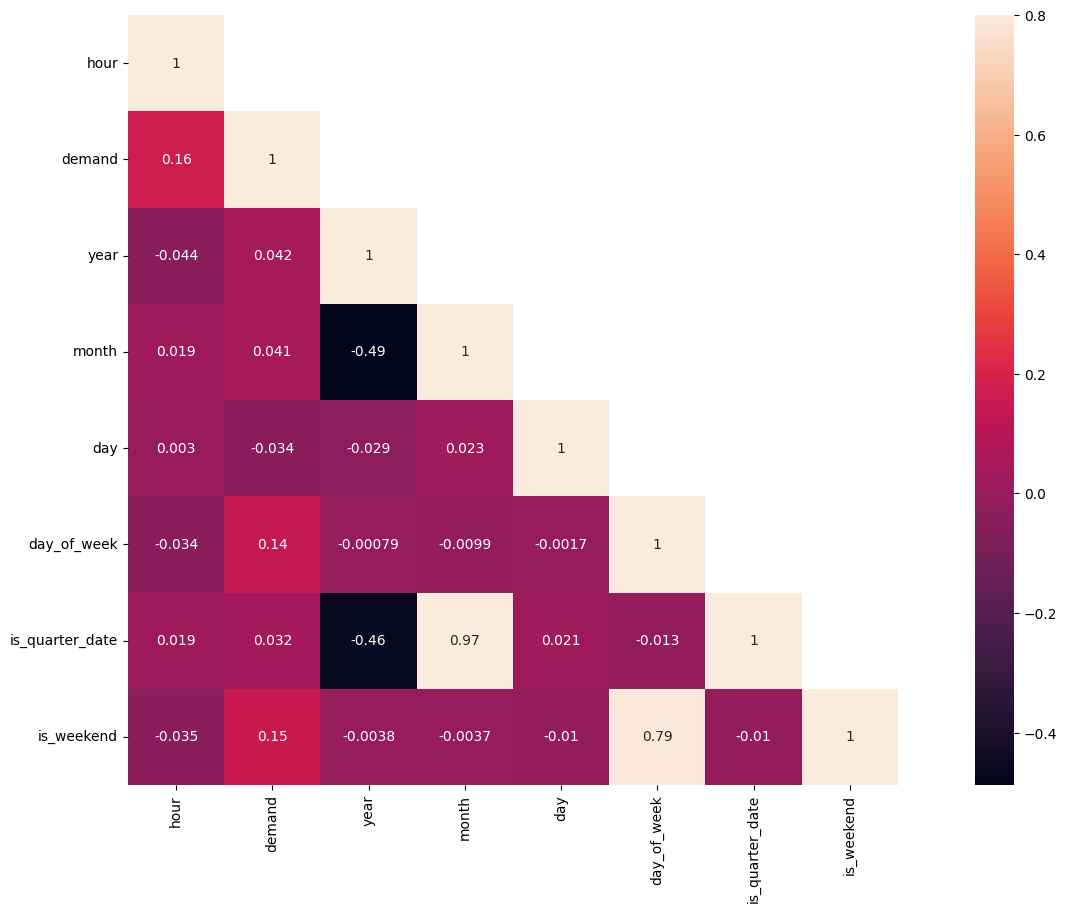

In [ ]:
# Checking the Correlation Between the Independent Variables

corr = df.corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corr, mask=mask,vmax=.8, square=True,annot=True)

##Modelling

In [ ]:
#split df into X & y
y = df['demand'].copy()
X = df.drop('demand', axis=1).copy()

In [ ]:
# Splitting data Into Training and Testing Set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=41)

In [ ]:
regressor = RandomForestRegressor(criterion='mse', random_state=123, max_depth=15, n_estimators=1000,min_samples_leaf=4, min_samples_split=2)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Correct the criterion parameter
regressor = RandomForestRegressor(criterion='squared_error')
regressor.fit(x_train, y_train)


RandomForestRegressor()

In [ ]:
regressor.fit(x_train, y_train)

RandomForestRegressor()

In [ ]:
y_pred = regressor.predict(x_test)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)


RMSE: 34.151539484777665


In [ ]:
gbm = lgb.LGBMRegressor(objective='regression', num_leaves=89,learning_rate=0.1,max_bin=200,min_sum_hessian_in_leaf = 20,
                        max_depth= 18,verbose=-1)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

best_rmse = np.inf
best_iteration = 0
no_improvement_count = 0
early_stopping_rounds = 100  # Define your patience for early stopping

for i in range(1, 1000 + 1):  # Replace 1000 with the maximum number of estimators
    gbm.set_params(n_estimators=i)
    gbm.fit(x_train, y_train, eval_set=[(x_test, y_test)], eval_metric='rmse')

    y_pred = gbm.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Manual computation of RMSE

    # Track the best RMSE and early stopping
    if rmse < best_rmse:
        best_rmse = rmse
        best_iteration = i
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= early_stopping_rounds:
        print(f"Early stopping at iteration {i}, best iteration was {best_iteration} with RMSE: {best_rmse:.4f}")
        break



Early stopping at iteration 140, best iteration was 40 with RMSE: 31.3279


In [ ]:
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration_)

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

31.388095641737472

##Predicting

In [ ]:
predict = gbm.predict(test)

In [ ]:
rounded = [round(x) for x in predict]
predict = rounded

In [ ]:
submit['demand'] = predict

In [ ]:
submit.head()

,date,hour,demand
0,2021-03-01,0,65
1,2021-03-01,1,51
2,2021-03-01,2,53
3,2021-03-01,3,51
4,2021-03-01,5,44
